In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\realy\AppData\Local\Temp\ipykernel_25188\3303615669.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

latest_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the dataset is:", latest_date)

The most recent date in the dataset is: 2017-08-23


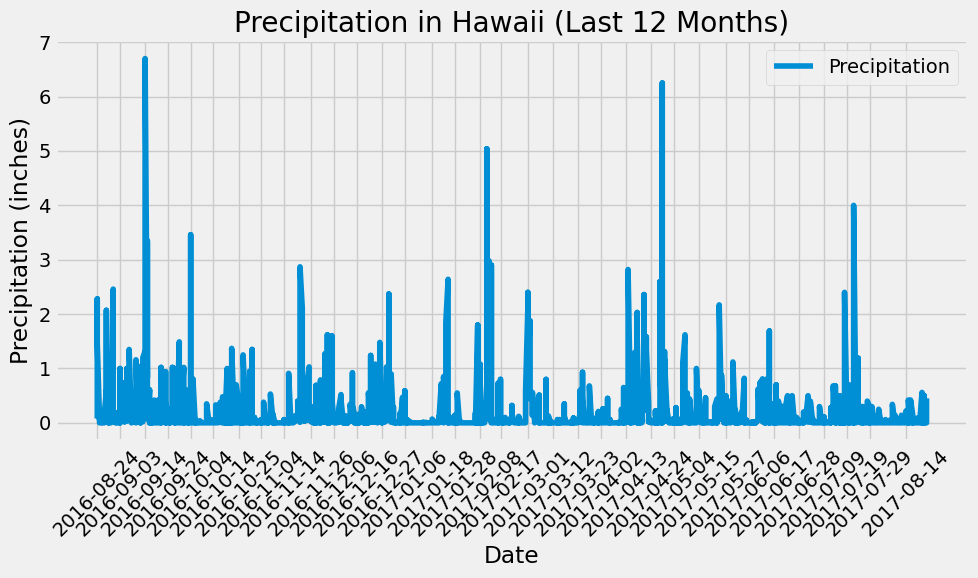

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

from datetime import datetime, timedelta
# Calculate the date one year from the last date in data set.

latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date = datetime.strptime(latest_date, '%Y-%m-%d')

one_year_ago = latest_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp)\
                  .filter(Measurement.date >= one_year_ago)\
                  .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df = df.dropna()

# Sort the dataframe by date
df = df.sort_values(by='Date')



# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Hawaii (Last 12 Months)')

# Set tick marks for every month
plt.xticks(df['Date'][::30], rotation=45)

# Set tick marks for every month
plt.xticks(df['Date'][::60], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()




In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data

df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()

# Print the list of stations and their counts
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")



Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
              .filter(Measurement.station == most_active_station)\
              .all()


print(f"Lowest Temperature: {temps[0][0]}")
print(f"Highest Temperature: {temps[0][1]}")
print(f"Average Temperature: {temps[0][2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


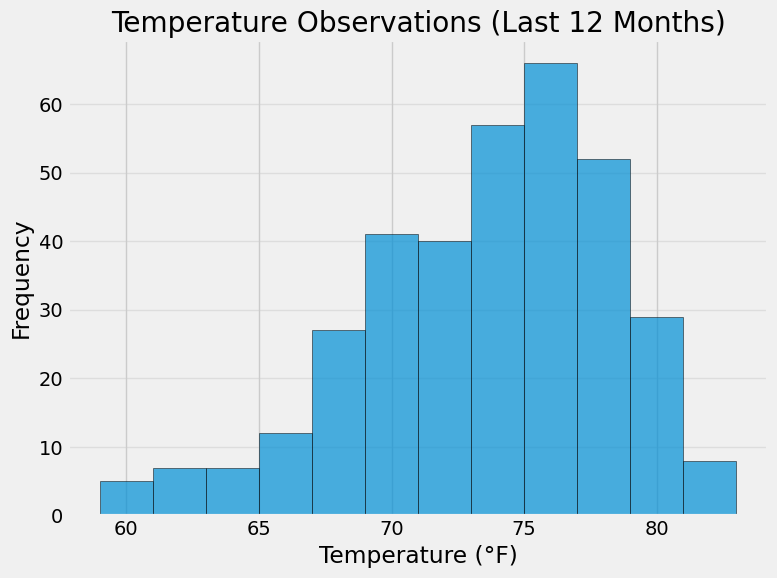

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date = datetime.strptime(latest_date, '%Y-%m-%d')

one_year_ago = latest_date - timedelta(days=365)

temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station)\
                          .filter(Measurement.date >= one_year_ago)\
                          .filter(Measurement.date <= latest_date)\
                          .all()

# Save the query results as a Pandas DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram of temperature observations
plt.figure(figsize=(8, 6))
plt.hist(df_temperature['Temperature'], bins=12, alpha=0.7, edgecolor='black')
plt.title('Temperature Observations (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()



# Close Session

In [27]:
# Close Session
session.close()